<a href="https://colab.research.google.com/github/QiliKiri/TensorFlow-2-for-Deep-Learning/blob/main/Week_3_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets-targets.mean(axis=0)) / targets.std()

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
                      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(1)
  ])
  return model

model = get_model()

In [7]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [10]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 1.1013 - mae: 0.7902


[1.101285696029663, 0.7902426719665527]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

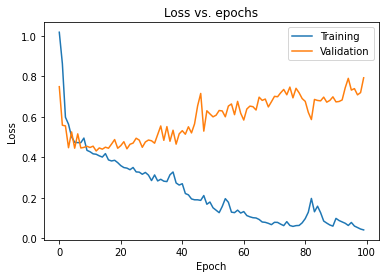

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [16]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, validation_split=0.15, batch_size=64, epochs=100, verbose=0)

In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=0)

[0.6734691262245178, 0.6430071592330933]

#### Plot the learning curves

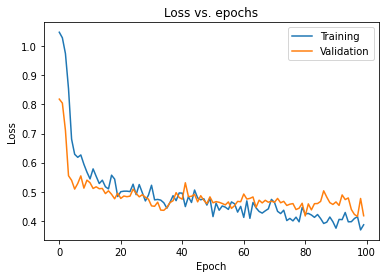

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class Training_callback(Callback):
  def on_train_begin(self, logs=None):
    print('Training start')

  def on_epoch_begin(self, epoch, logs=None):
    print(f'Epoch {epoch} starts')

  def on_train_batch_begin(self, batch, logs=None):
    print(f'Batch {batch} starts')

  def on_train_batch_end(self, batch, logs=None):
    print(f'Batch {batch} ends')

  def on_epoch_end(self, epoch, logs=None):
    print(f'Epoch {epoch} ends')

  def on_train_end(self, logs=None):
    print('Training ends')


In [21]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, callbacks=[Training_callback()], verbose=2)

Training start
Epoch 1/3
Epoch 0 starts
Batch 0 starts
Batch 0 ends
Batch 1 starts
Batch 1 ends
Batch 2 starts
Batch 2 ends
Batch 3 starts
Batch 3 ends
4/4 - 1s - loss: 1.0162
Epoch 0 ends
Epoch 2/3
Epoch 1 starts
Batch 0 starts
Batch 0 ends
Batch 1 starts
Batch 1 ends
Batch 2 starts
Batch 2 ends
Batch 3 starts
Batch 3 ends
4/4 - 0s - loss: 1.0074
Epoch 1 ends
Epoch 3/3
Epoch 2 starts
Batch 0 starts
Batch 0 ends
Batch 1 starts
Batch 1 ends
Batch 2 starts
Batch 2 ends
Batch 3 starts
Batch 3 ends
4/4 - 0s - loss: 0.9970
Epoch 2 ends
Training ends


In [24]:
class Testing_callback(Callback):
  def on_test_begin(self, logs=None):
    print('Testing start')

  def on_test_batch_begin(self, batch, logs=None):
    print(f'Batch {batch} starts')

  def on_test_batch_end(self, batch, logs=None):
    print(f'Batch {batch} ends')

  def on_test_end(self, logs=None):
    print('Testing ends')


In [25]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=2, callbacks=[Testing_callback()])

Testing start
Batch 0 starts
Batch 0 ends
Batch 1 starts
Batch 1 ends
2/2 - 0s - loss: 0.9138
Testing ends


0.9137585163116455

In [26]:
class Prediction_callback(Callback):
  def on_predict_begin(self, logs=None):
    print('Prediction start')

  def on_predict_batch_begin(self, batch, logs=None):
    print(f'Batch {batch} starts')

  def on_predict_batch_end(self, batch, logs=None):
    print(f'Batch {batch} ends')

  def on_predict_end(self, logs=None):
    print('Prediction ends')

In [27]:
# Make predictions with the model

model.predict(test_data, verbose=2, callbacks=[Prediction_callback()])

Prediction start
Batch 0 starts
Batch 0 ends
Batch 1 starts
Batch 1 ends
2/2 - 0s
Prediction ends


array([[0.06380541],
       [0.07755601],
       [0.11199065],
       [0.08898897],
       [0.04913283],
       [0.08166628],
       [0.0143605 ],
       [0.02879586],
       [0.02273765],
       [0.06267607],
       [0.03994486],
       [0.01864883],
       [0.07669346],
       [0.03178388],
       [0.07537795],
       [0.03169953],
       [0.1384358 ],
       [0.01243746],
       [0.09459057],
       [0.06377777],
       [0.0773668 ],
       [0.04872447],
       [0.09635731],
       [0.01439975],
       [0.03213387],
       [0.02831908],
       [0.0302244 ],
       [0.01969949],
       [0.03010421],
       [0.09819242],
       [0.11154386],
       [0.06243548],
       [0.02495967],
       [0.09216893],
       [0.05860312],
       [0.01914253],
       [0.0411036 ],
       [0.02179172],
       [0.07440442],
       [0.10121611],
       [0.04599643],
       [0.07853118],
       [0.01826365],
       [0.0836705 ],
       [0.11632819]], dtype=float32)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [35]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unregularised_history = unregularised_model.fit(train_data, train_targets,
                  epochs=100, batch_size=64, validation_split=0.15, verbose=False,
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [36]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.7025


0.70253586769104

In [37]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
regularised_history = regularised_model.fit(train_data, train_targets, 
                       epochs=100, batch_size=64, validation_split=0.15, verbose=False,
                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [38]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6626


0.6626418232917786

#### Plot the learning curves

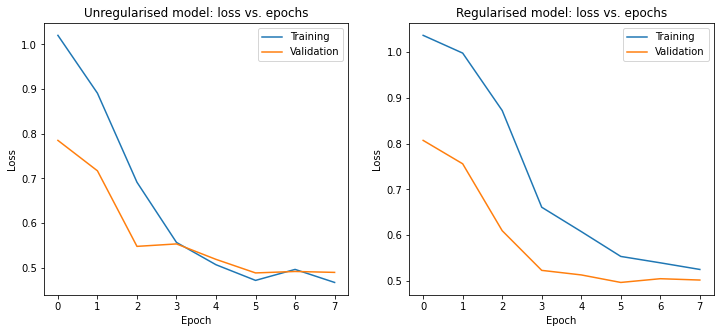

In [40]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unregularised_history.history['loss'])
plt.plot(unregularised_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(regularised_history.history['loss'])
plt.plot(regularised_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()